# __Python Twitter Sentiment Analysis for consumer marketing__
This project attempts to allow the user to determine what product they want a gerneral twitter sentiment analysis on, and then take the most popular users of that tweet and analyzes their tweets further to determine their favorite related products.

In [1]:
import re
import tweepy 
import pandas as pd
from tweepy import Cursor
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import tweepy 
import pandas as pd
from tweepy import Cursor
from textblob import TextBlob
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report
from sklearn import model_selection, svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer #Term Frequency — Inverse Document
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import emojis
import string
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Austin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


__Initialize authentication for the project__

In [2]:
class TwitterAnalysis: 
    #initialize authentication
    def __init__(self):
        consumer_key = 'dtJE96y6nYizN8puQASbj8qu6'
        consumer_secret = 'E0Nh7wCnrvqeXzl0aYHPXE9ZItU9inMCPzsUugplXWFUzub89H'
        access_token = '1513173502928506882-hssbphl2VShRQuTL2iwqwPJnTZPviP'
        access_token_secret = '66dcJVCniolrMuuc0M71SIGAFO0jHIPtfp46dWO8fpXCk'
        self.auth = tweepy.OAuth1UserHandler(
        consumer_key, consumer_secret, access_token, access_token_secret
        )
        self.api = tweepy.API(self.auth)\
    #Method that cleans tweets from unhelpful information for our model
    def tweetCleaner(self, tweet):
        wnl = WordNetLemmatizer() #reduce words down to its root, ie, dogs -> dog, flying -> fly
        #decode emojis in tweet
        cleanTweet = emojis.decode(tweet)
        
         # Remove all the special characters
        cleanTweet = ' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \s])|(\w+:\/\/\S+)", " ", tweet).split())
        
        #Remove numbers
        cleanTweet = re.sub(r'[0-9]', '', cleanTweet)
        wnl.lemmatize(cleanTweet)
        short = re.compile(r'\W*\b\w{1,3}\b')
        newTweet = short.sub('',cleanTweet)
        
        #tokenize tweets and then remove all 'stopwords' (https://stopwords.net/english-en/)
        tweets_tokens = nltk.word_tokenize(newTweet)
        lemmatized_tweet_tokens = [wnl.lemmatize(word) for word in tweets_tokens]
        tweetList = [word.lower() for word in lemmatized_tweet_tokens if not word in stopwords.words('english')]
        
        #Merge the tweet back into a string
        cleanedTweet = (" ").join(tweetList)
        
        return cleanedTweet

    
    #Get a dictionary of tweets with user ID's(ID's are easier to find)
    def tweetsDict(self, q, count = 5):
        textDict = {}
        for tweet in self.api.search_tweets(q = q , count = count):
            # We are filtering out neutral tweets since they are not going to be helpful
            if self.getSentiment(tweet.text) != 0:
                textDict[tweet.author.id] = tweet.text
        return textDict
    
    def tweetsDF(self, q, count, time):
        authors = []
        tweets = []
        sentiments = []
        creationDate = []
        for tweet in self.api.search_full_archive(query = q, label = 'BGTA', maxResults = count, toDate = time):
            cleanTweet = self.tweetCleaner(tweet.text)
            sentiment = self.getSentiment(cleanTweet)
            if sentiment != 0:
                authors.append(tweet.author.id)
                tweets.append(cleanTweet)
                creationDate.append(tweet.created_at)
            #textDict[tweet.author.id] = tweet.text
                sentiments.append(sentiment)
        tweets_df = pd.DataFrame({'Author': authors,'Cleaned Tweet': tweets,
                            'Sentiment': sentiments, 'Creation Date': creationDate})   
        return tweets_df

    
    #returns a specific users past [tweetCount] tweet
    def userTweets(self, userID, tweetCount = 25):
        i = 0
        tweets = []
        for status in Cursor(self.api.user_timeline,  user_id = userID).items():
            i += 1
            if self.getSentiment(status.text) != 0:
                tweets.append(status.text)
            
            if(i == tweetCount):
                break
        return tweets
    #Get the sentiment of a tweet. 
    
    
    def getSentiment(self, tweet):
        tweet = TextBlob(tweet)
        if tweet.sentiment.polarity > 0:
            return 'Positive'
        elif tweet.sentiment.polarity == 0:
            return 0
        else:
            return 'Negative'

__Retrieve the tweets from user timelines and from the last 7 days__ <br>
Here, we are gonna find a user from tweets that talk about the topic we want to market to, retrieve their most recent tweets and put that into a dataframe. <br> getUsers returns a dataframe of several users taken from a tweet about the and their top 100 tweets. Here, we will get a broader idea of a target market. <br> userTweets is used to retrieve the tweets from the specific user.

In [3]:
tweetSearch = TwitterAnalysis()
tweetSentiments = []
cleanTweets = []
tweetTuple = []
tweetTuples = []
dates = []
j = 0
def getUsers(topic, userCount, userTweets):
    usersWithTweets = tweetSearch.tweetsDict(topic, userCount) #Grab people tweeting about the topic, take the first one with opinions
    usersFound = []
    i = 0
    k = 1
    #Iterate through the dictionary keys(with tweet author id's)
    for key in usersWithTweets.keys():
        #print(key)
        tweets = tweetSearch.userTweets(key, userTweets)
        for tweet in tweets:
           # print(tweet)
                tweet = tweetSearch.tweetCleaner(tweet)
                sentiment = tweetSearch.getSentiment(tweet)
                if sentiment != 0:  
                    usersFound.append(key)
                    cleanTweets.append(tweet)
                    tweetSentiments.append(sentiment)
                
        
        #print(tweet)
    
        i += 1
        #Here, this check if they are actually opinionated people and not just informative sites(mostlt or all neutral sentiments)
        #If none of them are opinionated people(Empty df) rerun this block
        if(i == userCount):
            break
            
#Create a dataframe with the tweet from the user, and its sentiment
    df = pd.DataFrame({'Tweet': cleanTweets,
                           'Sentiment': tweetSentiments})
    usersFound = set(usersFound)
    print(len(usersFound), " users talking about ", topic, " found")
    return df



count = 100
topic = input("What topic would you like to get user analysis on? ")
userDf = getUsers(topic, count, 100);
#userDf.head()
j = 0
# Here we are creating a dataframe dedicated to previous years and tweets about that
#Since this is based off just roughly 30-50 tweets a month, it won't give too much overall information, but it could raise questions.
for year in [2017,2018,2019,2020,2021,2022]: 
    
    time = str(year) + '04220219'
    topicDf = tweetSearch.tweetsDF(topic, count, time)
    topicDf.to_csv("topicData"+str(j)+".csv")
    j += 1
userDf.to_csv("tweetData.csv") #In case we lose access to tweepy

What topic would you like to get user analysis on? Disney
52  users talking about  Disney  found


I should note we are not using this right now but if we want a dataframe of all tweets about the given topic, we will use this loop that goes throgh the dictionary values instead of keys. <br><br>

Next we want to segment off the positive tweets and take a look at them, let's see if we can find anything useful from these tweets that could assist us in finding a target market.

In [4]:
userDf = pd.read_csv("tweetData.csv") 
positiveCount = 0
positiveTweets = []
nouns = []
userDf['Sentiment'].value_counts().Positive
print("Percent of tweets that are positive: {:.2%}".format(userDf['Sentiment'].value_counts().Positive / userDf.shape[0]))
k = 0
for x in userDf['Sentiment']:
    if x == 'Positive':
        positiveTweets.append(userDf['Tweet'][k])
    k += 1


Percent of tweets that are positive: 65.46%


__Visualize the most important words in each users timeline__ <br>
Let's create a list of all the nouns in the tweets and see if there is something of interest that could be seen. To do this, we are going to use a wordcloud: https://www.datacamp.com/community/tutorials/wordcloud-python

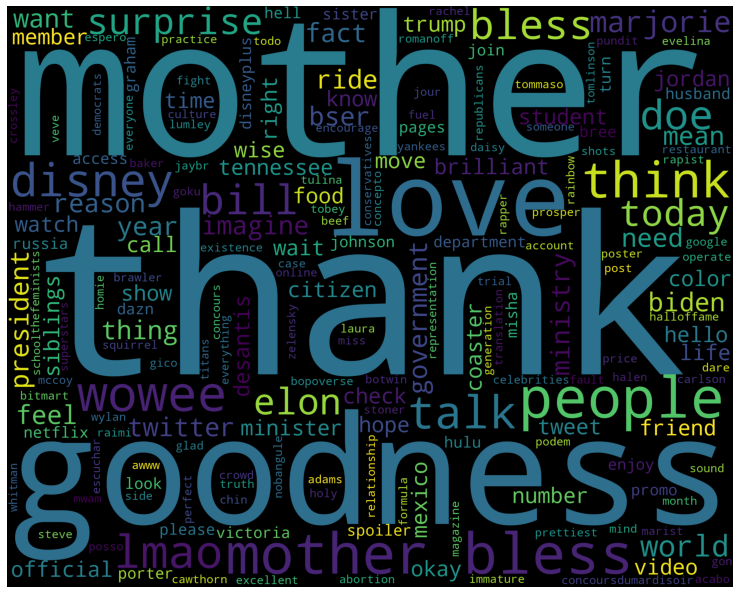

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Austin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Austin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
for z in positiveTweets:
        tokens = nltk.word_tokenize(z)
        #print(tokens)
        ans = nltk.pos_tag(tokens)
        val = ans[0][1]
        # ans returns a list of tuple
        if(val == 'NN' or val == 'NNS' or val == 'NNPS' or val == 'NNP' and val != 'disney'):
            nouns.append(ans[0][0])

releventTweets = " ".join(nouns)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', width=2500, height=2000).generate(releventTweets)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()




nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')  
for z in positiveTweets:
        tokens = nltk.word_tokenize(z)
        #print(tokens)
        ans = nltk.pos_tag(tokens)
        val = ans[0][1]
        # ans returns a list of tuple
        if(val == 'NN' or val == 'NNS' or val == 'NNPS' or val == 'NNP' and ans[0][0] != 'disney'):
            nouns.append(ans[0][0])



#      tweetSentiments.append(tweetSearch.getSentiment(tweet))
#      cleanTweets.append(tweetSearch.tweetCleaner(tweet))
#tweetDf = pd.DataFrame({'Tweet': cleanTweets,'Sentiment': tweetSentiments})

__Historical sentiment rating for each tweet__ <br>
Let's take a look at the additional topic dataframe which contains information on how the sentiment changed over the course of 5 years. Since tweepy is very strict, this will not be very broad, but if we want to see any controversial months in the previous few years, then we can also could get an idea as to what made this brand have a more mixed bag of negative and positive tweets.

,Unnamed: 0,Author,Cleaned Tweet,Sentiment,Creation Date
0,0,3191894340,qposket disney characters special coloring qpo...,Positive,2017
1,1,3419227425,normally accept,Positive,2017
2,2,33463380,sharethemagicsweepstakes halloween high sea di...,Positive,2017
3,3,2584668901,disney good walt disney world,Positive,2017
4,4,19373418,pinned ebay share your wares vintage disney mi...,Positive,2017
...,...,...,...,...,...
47,47,606755878,else would like disney tell desantis fuck move...,Negative,2022
48,48,4106256859,obamas kicked spotify canceled disney special ...,Positive,2022
49,49,1350232691564834816,disney ruin desantis election right announcing...,Positive,2022
50,50,1077732520572141575,there currently special taxing district florid...,Positive,2022


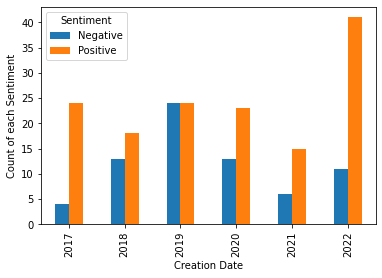

In [6]:
topicDf = [(pd.read_csv("topicData0.csv")),(pd.read_csv("topicData1.csv")),(pd.read_csv("topicData2.csv")),(pd.read_csv("topicData3.csv")),(pd.read_csv("topicData4.csv")),(pd.read_csv("topicData5.csv"))]
topicDf = pd.concat(topicDf)
topicDf['Creation Date'] = topicDf['Creation Date'].apply(lambda x: ' '.join(x[:4].split(' ')[:]) if len(x) > 4 else x)
topicDf

DfGraph = topicDf.groupby(by='Creation Date')['Sentiment'].value_counts()
Graph = DfGraph.unstack(level=1)
Graph.plot.bar(ylabel = 'Count of each Sentiment')
topicDf

__Vectorize each cleaned up tweet__ <br>
CountVectorizer turns text into a vector with the count of each word inside the text(tweet in this case) <br>
https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/#:~:text=CountVectorizer%20is%20a%20great%20tool%20provided%20by%20the,each%20word%20that%20occurs%20in%20the%20entire%20text.

In [7]:
countVect = CountVectorizer(stop_words='english')
countX = countVect.fit_transform(userDf['Tweet']) 

TfidfVectorizer is a different text-to-int method that instead of using word frequency in the sentence, it utilizes this AND word frequency in all documents(in this case, all tweets) and gives that word a weight of importance. We will be testing both methods.
<br>
https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
<br>
https://www.etutorialspoint.com/index.php/386-tf-idf-tfidfvectorizer-tutorial-with-examples

In [8]:
TfidfVect = TfidfVectorizer()
tfidfX = TfidfVect.fit_transform(userDf['Tweet']) 



target = userDf['Sentiment'].apply(lambda x: 0 if x=='Negative' else 1 )


Get the X and Y values, and then apply NLP methods to the tweets(which would be X here). Lambda allows us to go through the Sentiment column and give them int values to use in the ML model <br>
https://medium.com/geekculture/fit-vs-transform-vs-fit-transform-in-python-scikit-learn-2623d5a691e3 <br>
https://www.geeksforgeeks.org/python-lambda/#:~:text=%20Python%20lambda%20%201%20This%20function%20can,particular%20fields%20of%20programming%20besides%20other...%20More%20



__Use machine learning to predict a sentiment rating for a given tweet__ <br>
Here we are going to train an SVM model on the user dataframe model since it is significantly larger and predictions about how a subset of users could feel is more helpful than predictions from a smaller subset, for now. This will be done with these CountVectorizer and TfidfVectorizer methods of text analysis. Using both accuracy and F1 scores (https://deepai.org/machine-learning-glossary-and-terms/f-score).

In [15]:
#Set the train and test variables
x_trainCount, x_testCount, y_trainCount, y_testCount = train_test_split(countX, target, test_size=0.3, random_state=42)


x_trainTfidf, x_testTfidf, y_trainTfidf, y_testTfidf = train_test_split(tfidfX, target, test_size=0.3, random_state=42)

SVCmodelTfidf = SVC(kernel="linear", C=1.0)
SVCmodelTfidf.fit(x_trainTfidf, y_trainTfidf)


#Create the model
SVCmodelCount = SVC(kernel="linear", C=1.0)
SVCmodelCount.fit(x_trainCount, y_trainCount)

#Find the accuracy of the model
svc_predCount = SVCmodelCount.predict(x_testCount)
svc_accCount = metrics.accuracy_score(svc_predCount, y_testCount)
svc_predTfidf = SVCmodelTfidf.predict(x_testTfidf)
svc_accTfidf = metrics.accuracy_score(svc_predTfidf, y_testTfidf)
print(" Report for CV SVM: \n", classification_report(y_testCount, svc_predCount, target_names=['Negative', 'Positive']), "\n")
print(" Report for Tfidf SVM: \n", classification_report(y_testTfidf, svc_predTfidf, target_names=['Negative', 'Positive']))


 Report for CV SVM: 
               precision    recall  f1-score   support

    Negative       0.78      0.67      0.72       229
    Positive       0.83      0.89      0.86       419

    accuracy                           0.82       648
   macro avg       0.81      0.78      0.79       648
weighted avg       0.81      0.82      0.81       648
 

 Report for Tfidf SVM: 
               precision    recall  f1-score   support

    Negative       0.85      0.60      0.70       229
    Positive       0.81      0.94      0.87       419

    accuracy                           0.82       648
   macro avg       0.83      0.77      0.79       648
weighted avg       0.82      0.82      0.81       648



Results are similar, so the choice of vector method does not matter as much as it would seem for smaller datasets. Let's look at the confusion matrix. For the vectorization here and going forward we will stick with Tfidf, as it does not seem to make a drastric difference for this dataset.

THE ROC curve is a way to show how accurate the model was getting as it was getting fed a new vectorized tweet and a sentiment for it. The larger the area under teh curve, the better because the idea goal is keeping the true positive rate high and false positive rate low. The confusion matrix shows how many false positives and false negatives there are for each model prediction.

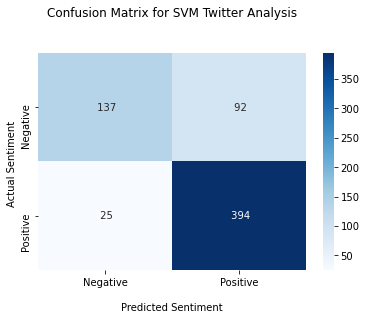

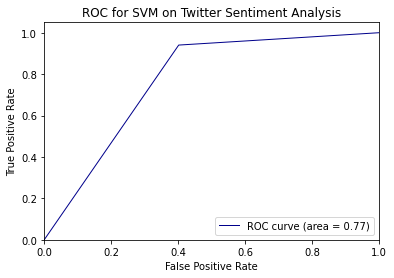

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

#Create the visualization for the Confusion Matrix
cf_matrixSVM = confusion_matrix(y_testTfidf, svc_predTfidf)
ax = sns.heatmap(cf_matrixSVM, annot=True, cmap='Blues', fmt=" ")
ax.set_title('Confusion Matrix for SVM Twitter Analysis\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment ');

# Set the classification labels to be positive and negative
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

# Display the visualization of the Confusion Matrix.
plt.figure(1,figsize=(18, 18))
plt.show()
fpr, tpr, thresholds = roc_curve(y_testTfidf, svc_predTfidf)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVM on Twitter Sentiment Analysis')
plt.legend(loc="lower right")


With a 30% test set we have 416 positives returned correctly predicted, with 173 negativees correctly predicted and 82 positives falsely predicted <br>
This shows some evidence that the higher percentage sentiment gives the model more accurate predictions, here it is positive.

Now let's try using a decision tree and see what accuracy we could pull from that

In [11]:
from sklearn import tree
clf = DecisionTreeClassifier()
clf = clf.fit(x_trainTfidf, y_trainTfidf)
y_predTree = clf.predict(x_testTfidf)



In [12]:
print("Accuracy for Decision Tree:",metrics.accuracy_score(y_testTfidf, y_predTree))
print(" Report for Tfidf Decision Tree: \n", classification_report(y_testTfidf,  y_predTree, target_names=['Negative', 'Positive']))

Accuracy for Decision Tree: 0.8070987654320988
 Report for Tfidf Decision Tree: 
               precision    recall  f1-score   support

    Negative       0.78      0.63      0.70       229
    Positive       0.82      0.90      0.86       419

    accuracy                           0.81       648
   macro avg       0.80      0.77      0.78       648
weighted avg       0.80      0.81      0.80       648



 Report for Tfidf Decision Tree: 
               precision    recall  f1-score   support

    Negative       0.78      0.63      0.70       229
    Positive       0.82      0.90      0.86       419

    accuracy                           0.81       648
   macro avg       0.80      0.77      0.78       648
weighted avg       0.80      0.81      0.80       648
 


Confusion Matrix for Decision Tree: 


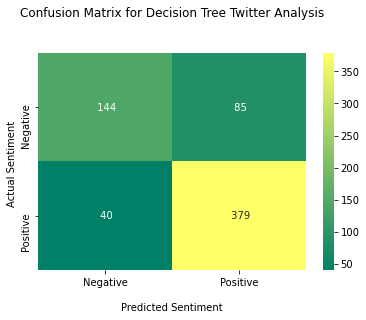

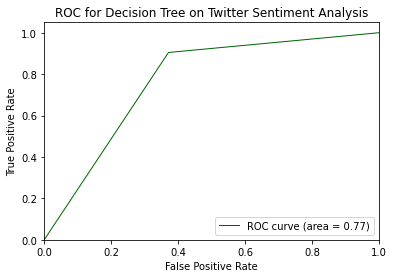

In [13]:
print(" Report for Tfidf Decision Tree: \n", classification_report(y_testTfidf,  y_predTree, target_names=['Negative', 'Positive']),"\n\n")
print("Confusion Matrix for Decision Tree: ")
cf_matrixTree = confusion_matrix(y_testTfidf, y_predTree)
ax = sns.heatmap(cf_matrixTree, annot=True, cmap='summer', fmt=" ")
ax.set_title('Confusion Matrix for Decision Tree Twitter Analysis\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment ');


ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])


plt.figure(1,figsize=(18, 18))
plt.show()
fpr, tpr, thresholds = roc_curve(y_testTfidf, y_predTree)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree on Twitter Sentiment Analysis')
plt.legend(loc="lower right")

Looks like the accuracy for SVM is better in both positive and negative sentiments overall, despite the tree having less false positive predictions <br><br>

Finally, let's take at look at a model based off of the conditional probability formula Bayes Theorem, the Naive Bayes Classifier. https://www.geeksforgeeks.org/naive-bayes-classifiers/ <br>
We will be using Multinomial: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB

 Report for Tfidf Naive Bayes: 
               precision    recall  f1-score   support

    Negative       0.86      0.19      0.31       229
    Positive       0.69      0.98      0.81       419

    accuracy                           0.70       648
   macro avg       0.78      0.59      0.56       648
weighted avg       0.75      0.70      0.64       648



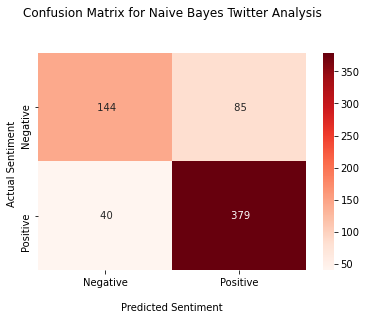

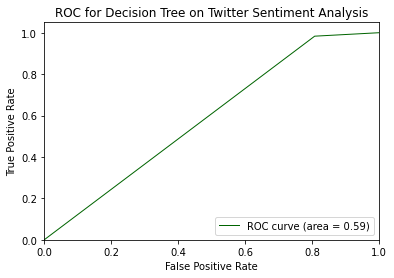

In [14]:
from sklearn.naive_bayes import MultinomialNB
NBayesSentiment = MultinomialNB()
NBayesSentiment.fit(x_trainTfidf, y_trainTfidf)
y_predNB = NBayesSentiment.predict(x_testTfidf)

print(" Report for Tfidf Naive Bayes: \n", classification_report(y_testTfidf,  y_predNB, target_names=['Negative', 'Positive']))

cf_matrixNB = confusion_matrix(y_testTfidf, y_predTree)

ax = sns.heatmap(cf_matrixNB, annot=True, cmap='Reds', fmt=" ")
ax.set_title('Confusion Matrix for Naive Bayes Twitter Analysis\n\n');
ax.set_xlabel('\nPredicted Sentiment')
ax.set_ylabel('Actual Sentiment ');

ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])


plt.figure(1,figsize=(18, 18))
plt.show()
fpr, tpr, thresholds = roc_curve(y_testTfidf, y_predNB)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Decision Tree on Twitter Sentiment Analysis')
plt.legend(loc="lower right")

Looks like SVM is the preferred model here with the highest accuracy and F1 score! The Naive Bayes model, as expected, was the least accurate. However it still performed well and shown that it can find accurate probability ratings with an imbalanced set of positive and negative tweets.